# CEE 690, Lecture 10 (Bonus SVM) Code Examples

This course will make use of notebook style coding.  Notebooks are incredibly useful tools both for teaching and for disseminating data anlysis.

This is a partial set of codes to look at SVM and show a few results.  This produces the results mentioned in lecture 10.

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

This section provides some initialization commands, which can simply be copied for assignments.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# We need to import key libraries that we're going to use.  
# For now this is just numpy, which is our linear algebra library
import numpy as np

Setting the random seed for code reproducibility.

In [2]:
# to make this notebook's output stable across runs, we are going to see the random seed
np.random.seed(42)

Note that we have to reset the random seed _every_ time we run an algorithm if we want the same results!

We also want to set up a plotting environment and make it look pretty.  For those of you familiar with matlab, we will be using matplotlib which is fairly close in syntax and feel.  It's not too far off from R either.

In [3]:
# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline 
# This command figures show up in the notebook.  It's a "magic" command...
# Typically, this now happens by default so it is often an unnecessary command, but is good for standardization.
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

These commands will help us save figures; not going to go through them so much.

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "10_svm"

In [5]:
# makes the directory if it doesn't exist.
import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn\'t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

Figure directory exists.


In [6]:
# a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

## Support Vector Machines

First we will make some one-dimensional data for regression (below is classification):

In [7]:
def f(x,noise_rate=.2):
    # assume feasible range on x is 0-1
    y=np.zeros(x.shape)
    for i in range(0,len(x)):
        if x[i]<.3:
            a=.25
        elif x[i]>.7:
            a=.1
        else:
            a=.75
        y[i]=a+np.random.randn()*noise_rate
    y=y-np.mean(y)
    return y

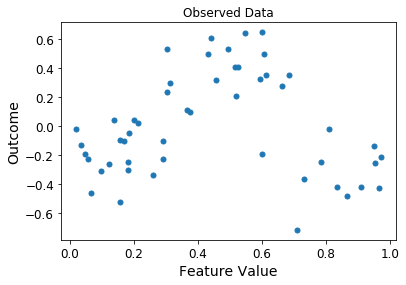

In [8]:
fig=plt.figure(figsize=[6,4])
np.random.seed(42)
x=np.sort(np.random.rand(50).reshape(-1,1),axis=0)
y=f(x).reshape(-1)
plt.plot(x,y,'.',ms=10)
plt.xlabel('Feature Value')
plt.ylabel('Outcome')
plt.title('Observed Data')
plt.show()

How would a kernel transform this data?

In [9]:
def rbf_vector(x,centers,gamma=100):
    return np.exp(-(x-centers)**2*gamma)

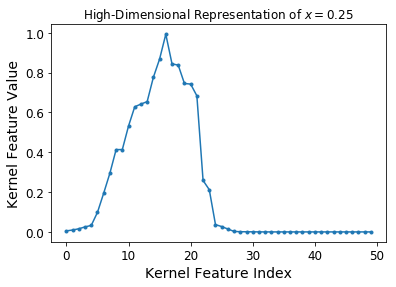

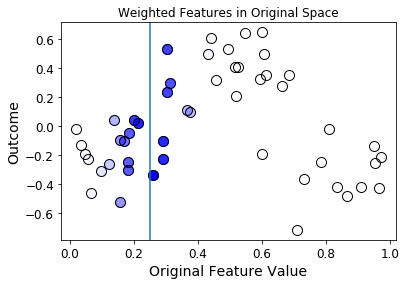

In [10]:
# Consider a new point x
x_new=.25
# in the kernel space constructed by the training points:
x_kern=rbf_vector(x_new,x)
# Let's visualize this is two ways:
fig1=plt.figure(figsize=[6,4])
plt.plot(x_kern,'.-')
plt.xlabel('Kernel Feature Index')
plt.ylabel('Kernel Feature Value')
plt.title('High-Dimensional Representation of $x={}$'.format(x_new))
plt.show()
#
import matplotlib as mpl
fig2=plt.figure(figsize=[6,4])
for i in range(0,len(x)):
    plt.plot(x[i],y[i],'bo',ms=10,alpha=x_kern[i])
plt.plot(x,y,'o',color='k',markerfacecolor='none',ms=10)
plt.axvline(x_new)
plt.xlabel('Original Feature Value')
plt.ylabel('Outcome')
plt.title('Weighted Features in Original Space')
plt.show()

Now we will apply an SVM to predict this regression problem:

In [11]:
# this function goes through and visualizes the data
def visualize_kernels(reg,gamma=100,minval=0,maxval=1):
    def rbf(x,center=0,gamma=20):
        return np.exp(-(x-center)**2*gamma)
    xi=np.linspace(minval,maxval,1001)
    bl=reg.intercept_
    for i in range(len(reg.support_vectors_)):
        w=reg.dual_coef_[0][i]       
        pr=w*rbf(xi,reg.support_vectors_[i],gamma=gamma)
        if w>0:     
            plt.fill(np.concatenate([[0.],xi,[1.]]),bl+\
                                    np.concatenate([[0.],pr,[0.]]),'r',alpha=.25)
            plt.plot([reg.support_vectors_[i],reg.support_vectors_[i]],[bl,bl+w],'--k',alpha=.5)
        else:
            plt.fill(np.concatenate([[0.],xi,[1.]]),bl+\
                                    np.concatenate([[0.],pr,[0.]]),'b',alpha=.25)
            plt.plot([reg.support_vectors_[i],reg.support_vectors_[i]],[bl,bl+w],'--k',alpha=.5)
    return None

17 vectors used


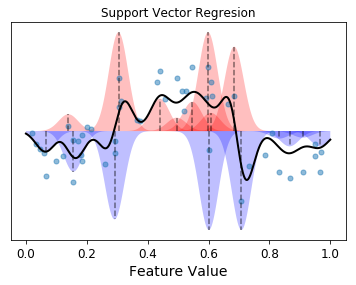

In [12]:
# First fit the model
from sklearn import svm
gamma=500
reg=svm.SVR(kernel='rbf',gamma=gamma,C=1.0,epsilon=0.25)
reg.fit(x,y)
print(str(len(reg.support_vectors_))+ ' vectors used')

xi=np.linspace(0,1,10001).reshape(-1,1)
yp=reg.predict(xi)

fig=plt.figure(figsize=[6,4])
plt.plot(x,y,'.',ms=10,alpha=.5)
# Plot without discontinuities
plt.xlabel('Feature Value')
#plt.ylabel('Outcome')
plt.yticks([])
plt.title('Support Vector Regresion')
plt.plot(xi,yp,'k',lw=2)
visualize_kernels(reg,gamma)
plt.show()

### Classification

In [13]:
# Here is a function that generates data of students taking a test.  It's just like the real thing!
def generate_students_pass_fail(n=200,pass_line=70,random_seed=42):
    def sigmoid(x):
        return 1./(1.+np.exp(-x))
    # Generates noisy data along curved line.
    # The curve is non-linear and the noise/variance is heteroskedastic and non-gaussian, so it breaks
    # pretty much all classical statistical model assumptions.  It's both pretty fun and kind of 
    # disturbing how easy it is to do that.
    np.random.seed(random_seed)
    x = 6*np.random.rand(n, 1)
    x = np.sort(x,axis=0)
    score = 100* sigmoid(-2+x+.4*np.random.randn(n,1))+5*np.random.randn(n,1)
    y=score>pass_line
    y=y.reshape(-1)
    return x,y

In [14]:
x,y=generate_students_pass_fail()

63 vectors used


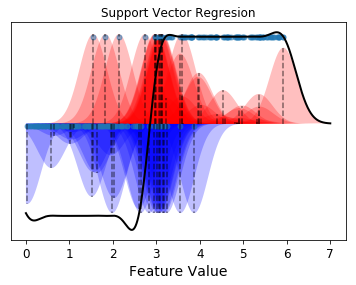

In [15]:
# First fit the model
from sklearn import svm
gamma=5
reg=svm.SVC(kernel='rbf',gamma=gamma,C=1.0)
reg.fit(x,y)
print(str(len(reg.support_vectors_))+ ' vectors used')
xi=np.linspace(0,7,10001).reshape(-1,1)
yp=reg.decision_function(xi)
fig=plt.figure(figsize=[6,4])
plt.plot(x,y,'.',ms=10,alpha=.5)
# Plot without discontinuities
plt.xlabel('Feature Value')
#plt.ylabel('Outcome')
plt.yticks([])
plt.title('Support Vector Regresion')
plt.plot(xi,yp,'k',lw=2)
visualize_kernels(reg,gamma,minval=0,maxval=7)
plt.show()